* https://x.com/genkuroki/status/1931490343368954196
* https://www.science.org/content/article/big-win-dubious-statistical-results-are-becoming-less-common-psychology
* https://journals.sagepub.com/doi/10.1177/25152459251323480

[Google Colabで実行](https://colab.research.google.com/github/genkuroki/public/blob/main/0054/LLN%20for%20Bin(30%2C%200.5).ipynb)

In [1]:
# Google Colabと自分のパソコンの両方で使えるようにするための工夫

using Pkg

"""すでにPkg.add済みのパッケージのリスト (高速化のために用意)"""
_packages_added = [sort!(readdir(Sys.STDLIB));
    [info.name for (uuid, info) in Pkg.dependencies() if info.is_direct_dep]]

"""_packages_added内にないパッケージをPkg.addする"""
add_pkg_if_not_added_yet(pkg) = if !(pkg in _packages_added)
    println(stderr, "# $(pkg).jl is not added yet, so let's add it.")
    Pkg.add(pkg)
end

"""expr::Exprからusing内の`.`を含まないモジュール名を抽出"""
function find_using_pkgs(expr::Expr)
    pkgs = String[]
    function traverse(expr::Expr)
        if expr.head == :using
            for arg in expr.args
                if arg.head == :. && length(arg.args) == 1
                    push!(pkgs, string(arg.args[1]))
                elseif arg.head == :(:) && length(arg.args[1].args) == 1
                    push!(pkgs, string(arg.args[1].args[1]))
                end
            end
        else
            for arg in expr.args arg isa Expr && traverse(arg) end
        end
    end
    traverse(expr)
    pkgs
end

"""必要そうなPkg.addを追加するマクロ"""
macro autoadd(expr)
    pkgs = find_using_pkgs(expr)
    :(add_pkg_if_not_added_yet.($(pkgs)); $expr)
end

@autoadd

In [2]:
using Random
@autoadd using Distributions
@autoadd using Plots
default(fmt=:png, legendfontsize=12)

[ Info: Saved animation to D:\OneDrive\public\0054\tmp.gif


Plots.AnimatedGif("D:\\OneDrive\\public\\0054\\tmp.gif")
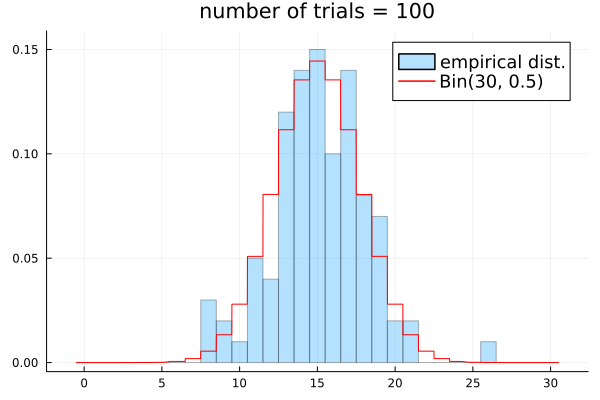

In [3]:
Random.seed!(4649373)

n, p = 30, 0.5
bin = Binomial(n, p)
M = 40000
X = rand(bin, M)

ms = round.(Int, range(sqrt(3000), sqrt(M), 100) .^ 2)
@gif for m in [100:2:298; 300:5:995; 1000:10:2990; ms; fill(ms[end], 80)]
    histogram(X[1:m]; norm=true, alpha=0.3, bin=-0.5:n+0.5, label="empirical dist.")
    plot!(x -> pdf(bin, round(Int, x)), -0.5, n+0.5; label="Bin($n, $p)", c=:red)
    plot!(xtick=0:5:n)
    plot!(ylim=(-0.03, 1.1) .* pdf(bin, n÷2))
    title!("number of trials = $m")
end